# 1a

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_error
import seaborn
seaborn.set(style="white", context="notebook", font_scale=1.5,
            rc={"axes.grid": True, "legend.frameon": False,
"lines.markeredgewidth": 1.4, "lines.markersize": 10})

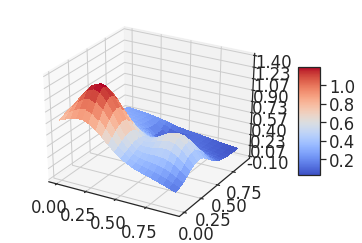

In [2]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
x = np.arange(0, 1, .05)#0.05)
y = np.arange(0, 1, .05)#0.05)

numberOfObservations = len(x)
xPlot, yPlot = np.meshgrid(x,y)


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


z = FrankeFunction(xPlot, yPlot)

# Plot the surface.
surf = ax.plot_surface(xPlot, yPlot, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [496]:
class LeastSquares:
    """ 
    Least squares estimation of 2D function.
    Takes in meshgrid versions of x, y and z
    """
    
    def __init__(self, xPlot, yPlot, zPlot, degree):
        self.xOrg, self.yOrg = xPlot[0], yPlot[:,0]
        self.numberOfObservations = len(self.xOrg)
        self.xPlot, self.yPlot, self.zPlot = xPlot, yPlot, zPlot
        self.x, self.y, self.z = xPlot.reshape(-1, 1), yPlot.reshape(-1, 1), zPlot.reshape(-1, 1)
        self.degree = degree
        
    def createDesignMatrix(self):
        x, y = self.x, self.y
        XHat = np.c_[x, y] 
        polynomialDegree = self.degree
        poly = PolynomialFeatures(polynomialDegree)
        self.XHat = poly.fit_transform(XHat)
        return self.XHat

    def estimate(self):
        XHat = self.XHat
        self.betaHat = np.linalg.inv(XHat.T.dot(XHat)).dot(XHat.T).dot(self.z)
        return self.betaHat
        
    def fit(self):
        XHat = self.XHat
        betaHat = self.betaHat
        self.zFit = XHat.dot(betaHat)
        return self.zFit
    
    def predict(self):
        XHat = self.XHat
        betaHat = self.betaHat
        self.zPredict = XHat.dot(betaHat)
        return self.zPredict
        
    def plot(self):
        xPlot, yPlot, zPlot = self.xPlot, self.yPlot, self.zPlot
        zPredict = self.zPredict
        #z = self.z
        zPredictPlot = np.reshape(zPredict, np.shape(zPlot))
        #zPredictPlot = zPredictPlot.T
        
        # Plot
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        surf = ax.plot_surface(xPlot, yPlot, zPredictPlot, cmap=cm.coolwarm,
                               linewidth=0, antialiased=False) 
        #ax.set_zlim(-1.50, 25.0)
        #ax.set_zlim(-0.10, 1.40)
        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
        fig.colorbar(surf, shrink=0.5, aspect=5)
        ax.set_title('Predicted')
        plt.show()
        
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        surf = ax.plot_surface(xPlot, yPlot, zPlot, cmap=cm.coolwarm,
                               linewidth=0, antialiased=False) 
        #ax.set_zlim(-1.50, 25.0)
        #ax.set_zlim(-0.10, 1.40)
        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
        fig.colorbar(surf, shrink=0.5, aspect=5)
        ax.set_title('True')
        plt.show()
        
        
        
    def calculateErrorScores(self):
        from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_error
        z, zPredict= self.z, self.zPredict
        mse = mean_squared_error(z, zPredict)
        r2 = r2_score(z, zPredict)
        print("Mean squared error: %.4f" % mse)
        print('R2 score: %.4f' % r2)
        return mse, r2

    def calculateVarianceBeta(self):
        lambdaRidge = 0
        XHat = self.XHat
        betaHat = self.betaHat
        x, z = self.x, self.z

        # Source Ridge estimator variance: https://arxiv.org/pdf/1509.09169.pdf
        shapeXXT = np.shape(XHat.T.dot(XHat))

        yFitted = XHat.dot(betaHat)
        predictionError2 = 1/(len(x) -1)*np.sum((z - yFitted)**2)

        coefficientVariancesSLR = np.linalg.inv(XHat.T.dot(XHat)).dot(predictionError2)
        W = np.linalg.inv(XHat.T.dot(XHat) + lambdaRidge*np.eye(shapeXXT[0], shapeXXT[1])).dot(XHat.T).dot(XHat) 
        self.varBeta = W.dot(coefficientVariancesSLR).dot(W.T)
        self.varBeta = np.diag(self.varBeta)
        #return varBeta
        
    
    def errorBootstrap(self, numberOfCrossTests=2, plot=False): 
        self.mseBootstrap = np.zeros(numberOfCrossTests)
        self.R2Bootstrap = np.zeros(numberOfCrossTests)
        betaList = [] # For variance calculation
        for iteration in range(numberOfCrossTests):
            # Training
            trainingIndices = [(np.random.randint(0, high=self.numberOfObservations), \
                      np.random.randint(0, high=self.numberOfObservations)) \
                     for i in range(self.numberOfObservations*self.numberOfObservations)]
            trainingIndices = np.array(trainingIndices)
            
            xTraining1D = self.xPlot[trainingIndices[:,0], trainingIndices[:,1]]
            yTraining1D = self.yPlot[trainingIndices[:,0], trainingIndices[:,1]]
            zTraining1D = self.zPlot[trainingIndices[:,0], trainingIndices[:,1]]
        
            XHat = np.c_[xTraining1D, yTraining1D]
            polynomialDegree = self.degree
            poly = PolynomialFeatures(polynomialDegree)
            XHat = poly.fit_transform(XHat)
            betaHat = np.linalg.inv(XHat.T.dot(XHat)).dot(XHat.T).dot(zTraining1D)
            betaList.append(betaHat)
            
            # Testing
            testIndexArray = np.zeros((self.numberOfObservations, self.numberOfObservations))
            testIndexArray[trainingIndices[:,0], trainingIndices[:,1]] = 1
            testIndices = np.argwhere(testIndexArray == 0)
            
            xTest1D = self.xPlot[testIndices[:,0], testIndices[:,1]]
            yTest1D = self.yPlot[testIndices[:,0], testIndices[:,1]]
            zTest1D = self.zPlot[testIndices[:,0], testIndices[:,1]]
                        
            XHat = np.c_[xTest1D, yTest1D]
            XHat = poly.fit_transform(XHat)
            zPredict = XHat.dot(betaHat)
            
            self.mseBootstrap[iteration] = mean_squared_error(zTest1D, zPredict)
            self.R2Bootstrap[iteration] = r2_score(zTest1D, zPredict)
        
        
        def movingAvg(array):
            n = len(array)
            cumsum  = np.cumsum(array)
            movingAverage  = np.cumsum(array)
            for counter in range(len(array)):
                movingAverage[counter] = cumsum[counter]/(counter+1)
            return movingAverage
        
        self.mseBootStrapMA = movingAvg(self.mseBootstrap)
        self.R2BootstrapMA = movingAvg(self.R2Bootstrap)
             
        def runningVariance(betaList):
            betaList = np.array(betaList)
            numberOfRuns, numberOfBetas = np.shape(betaList)
            varianceMatrix = np.zeros(np.shape(betaList))
            
            for runNumber in range(numberOfRuns):
                for betaNumber in range(numberOfBetas):
                    varianceMatrix[runNumber, betaNumber] = np.var(betaList[0:runNumber+1, betaNumber])
            return varianceMatrix
        
        self.varianceBeta =  runningVariance(betaList)
        
        if plot:
            fig, ax = plt.subplots()
            ax.plot(np.arange(1,len(self.mseBootStrapMA)+1), self.mseBootStrapMA)
            ax.set_title('Bootstrap \n Running Mean MSE')
            ax.set_xlabel('Number of bootsraps')
            ax.set_ylabel('Running mean MSE')
            
            fig2, ax2 = plt.subplots()
            ax2.plot(np.arange(1,len(self.R2BootstrapMA )+1), self.R2BootstrapMA )
            ax2.set_title('Bootstrap \n Running Mean R2')
            ax2.set_xlabel('Number of bootsraps')
            ax2.set_ylabel('Running Mean R2')
            
            fig3, ax3 = plt.subplots()
            ax3.plot(np.arange(1,len(self.R2BootstrapMA )+1), self.varianceBeta )
            ax3.set_title('Bootstrap \n Var(Beta) (Running)')
            ax3.set_xlabel('Number of bootsraps')
            ax3.set_ylabel('Var(Beta)')

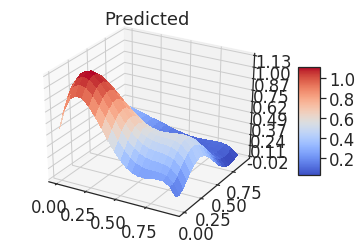

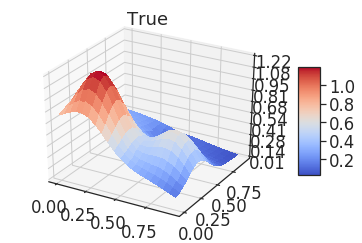

Mean squared error: 0.0022
R2 score: 0.9730

 Theoretical Var(beta) training set 
 [7.79428505e-04 1.26251727e-01 1.26251727e-01 3.59893706e+00
 2.07612442e+00 3.59893707e+00 2.11304247e+01 1.08656472e+01
 1.08656472e+01 2.11304248e+01 2.60486040e+01 1.42553287e+01
 1.20534728e+01 1.42553287e+01 2.60486040e+01 4.44480744e+00
 3.16473531e+00 2.92269927e+00 2.92269927e+00 3.16473531e+00
 4.44480745e+00] 


 Bootstrap Var(Beta) 
 [1.13164264e-02 9.93559701e-01 8.62750729e-01 1.41620911e+01
 1.61048274e+01 1.17399436e+01 4.82207761e+01 6.06905744e+01
 5.15622254e+01 4.14409442e+01 4.10279215e+01 5.18121485e+01
 4.67806328e+01 3.93564119e+01 3.65088177e+01 5.61494443e+00
 6.83185021e+00 6.92773415e+00 6.40879490e+00 5.01372966e+00
 4.97463140e+00] 


 boot/thery [1351.88768099  686.96721405  583.3575638   293.50760613  675.71590534
  226.20585968  128.2054274   458.55462116  374.54352747   96.11978798
   57.5052603   263.45811181  288.10916766  176.08210701   40.15652292
   26.32593213  115

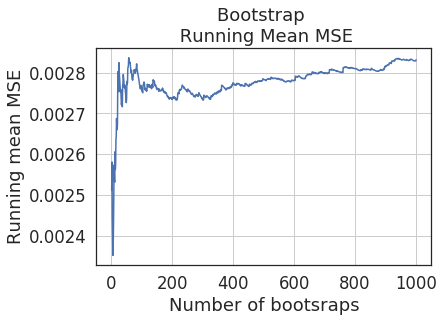

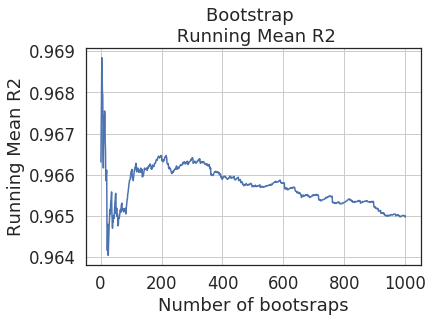

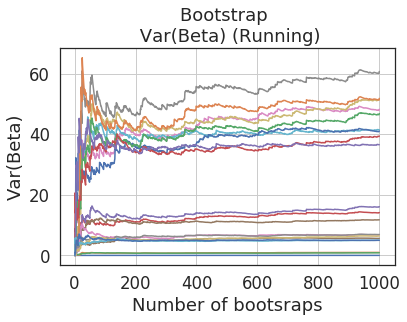

In [500]:
# Testing class

x = np.arange(0, 1, .05)#0.05)
y = np.arange(0, 1, .05)#0.05)

xPlot, yPlot = np.meshgrid(x,y)

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

zPlot = FrankeFunction(xPlot, yPlot)
degree = 5
ls = LeastSquares(xPlot, yPlot, zPlot, degree)
ls.createDesignMatrix()
ls.estimate()
ls.fit()
ls.predict()
ls.plot()
ls.calculateErrorScores()
ls.calculateVarianceBeta()
print('\n Theoretical Var(beta) training set \n', ls.varBeta, '\n')
ls.errorBootstrap(numberOfCrossTests=1000, plot=True)

print('\n Bootstrap Var(Beta) \n', ls.varianceBeta[-1], '\n')

print('\n boot/thery', (ls.varianceBeta[-1]/ls.varBeta-1)*100, '\n')


The plot above shows tha there is a huge difference between the predicted and the true solution in a small area of the domain. At most the predicted solution is approximately 20 times larger than the true solution. The error scores are very good. However, looking at the figure above, we see that low error scores are no guarantee for the fit being good over the whole domain.

### Sci-kit learn: test

In [392]:
# Scitkit learn TEST
from sklearn.linear_model import LinearRegression

x = np.arange(0, 1, .05)#0.05)
y = np.arange(0, 1, .05)#0.05)

xPlot, yPlot = np.meshgrid(x,y)

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

zPlot = FrankeFunction(xPlot, yPlot)

x = np.reshape(xPlot, -1, 1)
y = np.reshape(yPlot, -1, 1)
z = np.reshape(zPlot, -1, 1)

XHat = np.c_[x, y]
degree = 5
polynomialDegree = degree
poly = PolynomialFeatures(polynomialDegree)
XHat = poly.fit_transform(XHat)

linreg = LinearRegression()
linreg.fit(XHat, z)
predict = linreg.predict(XHat)

print('Intercept: ', linreg.intercept_)
print('Coefficients: ', linreg.coef_)
print("Mean squared error: %.4f" % mean_squared_error(z, predict))
print('R2 score: %.4f' % r2_score(z, predict))

# Plotting
predictPlot = np.reshape(predict, np.shape(zPlot))
#print(predictPlot)

x2Plot = np.reshape(x, np.shape(zPlot))
x2Plot = x2Plot.T
print('\n x2Plot \n', x2Plot)
print('\n xPlot \n', xPlot, '\n')

y2Plot = np.reshape(y, np.shape(zPlot))
y2Plot = y2Plot.T
print('\n y2Plot \n', y2Plot)
print('\n yPlot \n', yPlot, '\n')

z = np.reshape(zPlot, -1, 1)
z2Plot = np.reshape(z, np.shape(zPlot))
z2Plot = z2Plot.T
print('\n z2Plot \n', z2Plot)
print('\n zPlot \n', zPlot, '\n')

'''
# PLotting
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()
'''

Intercept:  0.5481633661827785
Coefficients:  [  0.           5.74654984   2.99559795 -24.03100583 -11.2601328
  -5.9653651   25.93438393  33.66372884  18.50345617 -14.08913347
  -0.90760655 -42.65810161  -1.189173   -31.71166945  36.40198929
  -7.37090174  15.88544529   6.62934981  -5.92131254  18.508273
 -19.78809639]
Mean squared error: 0.0022
R2 score: 0.9730

 x2Plot 
 [[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
  0.7  0.75 0.8  0.85 0.9  0.95]
 [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
  0.7  0.75 0.8  0.85 0.9  0.95]
 [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
  0.7  0.75 0.8  0.85 0.9  0.95]
 [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
  0.7  0.75 0.8  0.85 0.9  0.95]
 [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
  0.7  0.75 0.8  0.85 0.9  0.95]
 [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
  0.7  0.75 0.8  0.85 0.9 

"\n# PLotting\nfig = plt.figure()\nax = fig.gca(projection='3d')\nsurf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,\n                       linewidth=0, antialiased=False)\n\n# Customize the z axis.\nax.set_zlim(-0.10, 1.40)\nax.zaxis.set_major_locator(LinearLocator(10))\nax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))\n\n# Add a color bar which maps values to colors.\nfig.colorbar(surf, shrink=0.5, aspect=5)\n\nplt.show()\n"

In [125]:
data = x
bootVec = np.zeros(len(data))

for k in range(len(x)):        
    #print(np.random.choice(data, len(data)))
    bootVec[k] = np.average(np.random.choice(data, len(data)))
#print(bootVec)

a = np.array((1,2,3,4, 5, 6,7,8,9))
b = np.array((1,1,2,4))
c = np.nonzero(np.in1d(a, b))[0]
print('c', c, 'a[c]', a[c])
d = np.nonzero(np.isin(a,b))[0]
print('d', d)
e = np.isin(a,b)
print('e', e)
#f = bindices_zero = (e == 0)
#print('f', f)
g = np.logical_not(e>0)
print('g', g)
h = np.nonzero(g)[0]
print('h', h)
i = a[h]
print('i', i)



c [0 1 3] a[c] [1 2 4]
d [0 1 3]
e [ True  True False  True False False False False False]
g [False False  True False  True  True  True  True  True]
h [2 4 5 6 7 8]
i [3 5 6 7 8 9]


In [126]:
a = np.array((1,2,3,4, 5, 6,7,8,9))
b = np.array((1,1,2,4))

d = np.nonzero(np.isin(a,b))[0]
print('d', d)
e = np.isin(a,b)
print('e', e)
#f = bindices_zero = (e == 0)
#print('f', f)
g = np.logical_not(e>0)
print('g', g)
h = np.nonzero(g)[0]
print('h', h)
i = a[h]
print('i', i)


d [0 1 3]
e [ True  True False  True False False False False False]
g [False False  True False  True  True  True  True  True]
h [2 4 5 6 7 8]
i [3 5 6 7 8 9]


In [21]:
x = np.arange(0, 1, .25)#0.05)
y = np.arange(0, 1, .25)#0.05)
xPlot, yPlot = np.meshgrid(x,y)
xPlot2 = xPlot[0]
yPlot[:,0]
z1 = FrankeFunction(xPlot, yPlot)
print('z1', z1)

x2, y2 = np.reshape(xPlot, -1, 1),  np.reshape(yPlot, -1, 1)
z2 = FrankeFunction(x2, y2)
print('\n z2', z2)
print('\n z1 reshape', np.reshape(z1, -1, 1))
print('z1 reshape == z2', np.reshape(z1, -1, 1) == z2)

z2[[0,3]]

z1[0,0]

z1 [[0.76642059 0.81885368 0.43491424 0.25206195]
 [0.80258259 1.16528332 0.53811211 0.58935857]
 [0.48180615 0.50456938 0.32576209 0.40804792]
 [0.33952742 0.27241325 0.04371943 0.1159698 ]]

 z2 [0.76642059 0.80258259 0.48180615 0.33952742 0.81885368 1.16528332
 0.50456938 0.27241325 0.43491424 0.53811211 0.32576209 0.04371943
 0.25206195 0.58935857 0.40804792 0.1159698 ]

 z1 reshape [0.76642059 0.80258259 0.48180615 0.33952742 0.81885368 1.16528332
 0.50456938 0.27241325 0.43491424 0.53811211 0.32576209 0.04371943
 0.25206195 0.58935857 0.40804792 0.1159698 ]
z1 reshape == z2 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


0.7664205912849231

In [121]:
z1[[0, 2],[1,3]]

array([0.81885368, 0.40804792])

In [168]:
np.random.seed(1)
xPlot
indices =  np.asarray(np.random.randint(0, high=4, size=2))
indices =  [repr(np.random.randint(0, high=4, size=2)) for i in range(4)]
print('Indices \n', indices)
print('Indices[0] \n', indices[0])


indice1 = np.random.randint(0, high=4)
indice2 = np.random.randint(0, high=4)
print('indice1, indice1',indice1, indice1)


#indices =  np.asarray([np.random.randint(0, high=4, size=2) for i in range(4)])
#indices =  np.asarray(np.random.randint(0, high=4, size=2) for i in range(4))
#print('\n indicers \n', indices)
index = [[np.random.randint(0, high=4), np.random.randint(0, high=4)] for i in range(3)]
index = [(np.random.randint(0, high=4), np.random.randint(0, high=4)) for i in range(3)]
print('\n index \n', index)
print('\n index[0]', index[0], '\n')
grid = np.random.random((5, 5))
print(grid, '\n')
#grid[index[0]]
#print('\n grid(indices[0] \n', grid[index])
a = np.array([grid[index[i]] for i in range(len(index))])
print('\n a \n', a)

x = np.arange(0, 1, .25)#0.05)
y = np.arange(0, 1, .25)#0.05)
xPlot, yPlot = np.meshgrid(x,y)
z1 = FrankeFunction(xPlot, yPlot)
print('\n zi \n', z1)
z1[index[:]]

#print('\n z1[index[0]] \n', z1[index])

Indices 
 ['array([0, 0])', 'array([3, 1])', 'array([3, 1])', 'array([3, 0])']
Indices[0] 
 array([0, 0])
indice1, indice1 0 0

 index 
 [(2, 0), (2, 1), (2, 0)]

 index[0] (2, 0) 

[[0.20445225 0.87811744 0.02738759 0.67046751 0.4173048 ]
 [0.55868983 0.14038694 0.19810149 0.80074457 0.96826158]
 [0.31342418 0.69232262 0.87638915 0.89460666 0.08504421]
 [0.03905478 0.16983042 0.8781425  0.09834683 0.42110763]
 [0.95788953 0.53316528 0.69187711 0.31551563 0.68650093]] 


 a 
 [0.31342418 0.69232262 0.31342418]

 zi 
 [[0.76642059 0.81885368 0.43491424 0.25206195]
 [0.80258259 1.16528332 0.53811211 0.58935857]
 [0.48180615 0.50456938 0.32576209 0.40804792]
 [0.33952742 0.27241325 0.04371943 0.1159698 ]]


/home/k/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


IndexError: too many indices for array

In [227]:
import numpy as np
np.random.seed(1)
x = np.arange(0, 1+.1, .25)
y = np.arange(0, 1+.1, .25)
x, y = np.meshgrid(x,y)
print('\n x \n', x,)

index = [(np.random.randint(0, high=len(x)), np.random.randint(0, high=len(x))) for i in range(len(x))]
print('\n index \n', index)

for indexNumber in range(len(index)):
    #print(x[index[0]])
    print('\n index[%d]:' %indexNumber, index[indexNumber], '\n x[index[%d]] \n' %indexNumber, x[index[indexNumber]])
    
idx=np.array(index)
print('\n idx ', idx, '\n' )
x[idx[:,0], idx[:,1]]
print('\n x[idx[:,0], idx[:,1]] ', x[idx[:,0], idx[:,1]], '\n' )

fullarray = np.zeros((len(x), len(x)))
fullarray[idx[:,0], idx[:,1]] = 1
print('\n fullarray', fullarray, '\n')


whereZeroElements = np.argwhere(fullarray == 0)#np.where(zeroElements == True)
print('\n whereZeroElements \n', whereZeroElements, '\n')

print('\n fullarray[whereZeroElements[:,0], whereZeroElements[:,1]] \n', \
      fullarray[whereZeroElements[:,0], whereZeroElements[:,1]], '\n' )


 x 
 [[0.   0.25 0.5  0.75 1.  ]
 [0.   0.25 0.5  0.75 1.  ]
 [0.   0.25 0.5  0.75 1.  ]
 [0.   0.25 0.5  0.75 1.  ]
 [0.   0.25 0.5  0.75 1.  ]]

 index 
 [(3, 4), (0, 1), (3, 0), (0, 1), (4, 4)]

 index[0]: (3, 4) 
 x[index[0]] 
 1.0

 index[1]: (0, 1) 
 x[index[1]] 
 0.25

 index[2]: (3, 0) 
 x[index[2]] 
 0.0

 index[3]: (0, 1) 
 x[index[3]] 
 0.25

 index[4]: (4, 4) 
 x[index[4]] 
 1.0

 idx  [[3 4]
 [0 1]
 [3 0]
 [0 1]
 [4 4]] 


 x[idx[:,0], idx[:,1]]  [1.   0.25 0.   0.25 1.  ] 


 fullarray [[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]] 


 whereZeroElements 
 [[0 0]
 [0 2]
 [0 3]
 [0 4]
 [1 0]
 [1 1]
 [1 2]
 [1 3]
 [1 4]
 [2 0]
 [2 1]
 [2 2]
 [2 3]
 [2 4]
 [3 1]
 [3 2]
 [3 3]
 [4 0]
 [4 1]
 [4 2]
 [4 3]] 


 fullarray[whereZeroElements[:,0], whereZeroElements[:,1]] 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 



In [495]:
array = np.arange(4)
#print(array, '\n')
b = np.cumsum(array[:1])
#b
#array[:6]

np.var(array[0:2])

c = [[0, 1,2], [10,20,30]]
#d = np.var(c[0][0:2])
print(c[:][0:1])
#print(d)
d = np.array(c)

e = np.random.random((3, 3))
print(e)
f = np.diag(e)
print(f)


[[0, 1, 2]]
[[2.97970800e-02 7.66341825e-02 5.57399577e-01]
 [9.85968952e-01 4.52787746e-01 1.60255927e-01]
 [7.56287450e-05 6.32995215e-01 5.66911032e-02]]
[0.02979708 0.45278775 0.0566911 ]
